<i>gesture space</i>. <br><img src="./images/envision_banner.png"></center><br>
<center><h1> Kinematic Feature Extraction for Motion Tracking Analysis </h1>


<h3> James Trujillo ( james.trujillo@donders.ru.nl )<br>Wim Pouw ( wim.pouw@donders.ru.nl )<br>
    updated: 22-06-2023 </h3>
    

<h3> Info documents </h3>
This module demonstrates provides an example of how to analysis motion tracking data using kinematic feature extraction. In other words, we will take a motion/gesture event and calculate various kinematic features, such as the size, peak velocity, and number of submovements. 
<br><br>

* Original kinematic feature extraction citation:
Trujillo, J.P., Vaitonyte, J., Simanova, I. et al. Toward the markerless and automatic analysis of kinematic features: A toolkit for gesture and movement research. Behav Res 51, 769–777 (2019). https://doi.org/10.3758/s13428-018-1086-8 


* for the same code with additional options (such as specifying the time window for which you'd like to extract motion data, extra plotting options) and a MATLAB version of the code, see the following Github repository: <br>
https://github.com/jptrujillo/kinematic_feature_extract

* Module citation: 
Trujillo, J.P. & Pouw, W.T.J.L.  (2021-11-18). <i> Kinematic Feature Extraction for Motion Tracking Analysis </i> \[day you visited the site]. Retrieved from: https://github.com/WimPouw/EnvisionBootcamp2021/tree/main/Python/Analysis_kinematic_features
<br>
<h3>Introduction</h3>
Kinematic feature analysis is one way to look at the characteristics of a particular 'motion event'. This may be a gesture, a string of gestures, or a very specific movement. Either way, we are interested in some way to characterized the <i>way</i> the movement was performed. We therefore aren't trying to classify it or understand its meaning necessarily. Instead, this analysis is particularly useful for looking at different groups of gestures/movements. For example, it has been used to show that instrumental actions and gestures are kinematically different depending on: the social context in which they are performed (Trujillo et al., 2018; https://doi.org/10.1016/j.cognition.2018.04.003 ),whether performed by autistic or neurotypical individuals (Trujillo, Özyürek, Kan, Sheftel-Simanova & Bekkering, 2021; DOI: 10.1002/aur.2611), the amount of background noise in which they are produced (Trujillo,  Özyürek, Holler, & Drijvers, 2021; https://doi.org/10.1038/s41598-021-95791-0), and that these differences are directly related to comprehension.<br>
For this module, we'll use the example video of the man performing a silent iconic gesture for <i>accordion</i>. This provides a fairly clear visual example of how the kinematics relate to the movements, although this approach can of course be applied to other types of gestures or actions.

First, we're going to use the same json importing function introduced in the OpenPose module. We'll also use the OpenPose data here, but it's completely possible to use this with MediaPipe data as well. <br>
So first let's define our main import function, and then we'll go through our kinematic features one by one.

In [3]:
"""
Imports the json files and collects seperate variables for each joint of interest.
These are used for subsequent Analyze script, and are also saved for data inspection.

Output: Velocity vectors for each hand; tracking-confidence for each hand; velocity & confidence plots


Created on Tue Jan 29 16:01:29 2019
@author: James Trujillo
"""

import os
import matplotlib.pyplot as plt
import math
import csv
import numpy as np
import json
import pandas as pd
import zipfile
from scipy import signal


def import_json_data(vid_path):
    FPS = 25

    if os.path.isdir(vid_path):

        files = sorted(os.listdir(vid_path))
        R_Hand = []
        L_Hand = []
        Nose = []
        Neck = []
        MidHip = []
        REye = []
        LEye = []
        LElb = []
        RElb = []
        LHip = []
        RHip = []
        LEar = []
        REar = []
        LShoulder = []
        RShoulder = []


        valid_num = 0  # marker for most recent valid file. Used for exception handling
        ref = 1500
        for num, file in enumerate(files):
            miss_data = 0

            if file.endswith(".json"):
                filename = os.path.join(vid_path, file)

                # load the data. keypoints are given as x,y,confidence

                try:
                    with open(filename, 'r') as f:
                        datastore = json.load(f)
                        valid_num = num
                # if the .json is empty, re-use the previous one
                except:
                    if num > 1:
                        with open(os.path.join(vid_path, files[valid_num]), 'r') as f:
                            datastore = json.load(f)
                    else:
                        miss_data = 1
                        break
                reload = False              
                
                person_num = 0 # you can dynamically set this if there are multiple people in frame

                # store the Hand Points
                x = datastore["people"][person_num]["pose_keypoints_2d"][4 * 3]  
                y = datastore["people"][person_num]["pose_keypoints_2d"][(4 * 3) + 1]
                R_Hand.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][7 * 3]
                y = datastore["people"][person_num]["pose_keypoints_2d"][(7 * 3) + 1]
                L_Hand.append([x, y])
                # store body points
                x = datastore["people"][person_num]["pose_keypoints_2d"][0]  # 0 = Nose
                y = datastore["people"][person_num]["pose_keypoints_2d"][(0) + 1]
                Nose.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][1 * 3]  # 1 = Neck (Mid shoulder)
                y = datastore["people"][person_num]["pose_keypoints_2d"][(1 * 3) + 1]
                Neck.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][8 * 3]  # 8 = Mid Hip
                y = datastore["people"][person_num]["pose_keypoints_2d"][(8 * 3) + 1]
                MidHip.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][15 * 3]  # 15 = REye
                y = datastore["people"][person_num]["pose_keypoints_2d"][(15 * 3) + 1]
                REye.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][16 * 3]  # 16 = LEye
                y = datastore["people"][person_num]["pose_keypoints_2d"][(16 * 3) + 1]
                LEye.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][3 * 3]  # 3 = RElb
                y = datastore["people"][person_num]["pose_keypoints_2d"][(3 * 3) + 1]
                RElb.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][6 * 3]  # 6 = LElb
                y = datastore["people"][person_num]["pose_keypoints_2d"][(6 * 3) + 1]
                LElb.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][12 * 3]  # 12 = LHip
                y = datastore["people"][person_num]["pose_keypoints_2d"][(12 * 3) + 1]
                LHip.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][9 * 3]  # 9 = RHip
                y = datastore["people"][person_num]["pose_keypoints_2d"][(9 * 3) + 1]
                RHip.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][18 * 3]  # 18 = LEar
                y = datastore["people"][person_num]["pose_keypoints_2d"][(18 * 3) + 1]
                LEar.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][17 * 3]  # 17 = REar
                y = datastore["people"][person_num]["pose_keypoints_2d"][(17 * 3) + 1]
                REar.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][5 * 3]  # 5 = L shoulder
                y = datastore["people"][person_num]["pose_keypoints_2d"][(5 * 3) + 1]
                LShoulder.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][2 * 3]  # 2 = R shoulder
                y = datastore["people"][person_num]["pose_keypoints_2d"][(2 * 3) + 1]
                RShoulder.append([x, y])
                
                prev_file = datastore
                prev_hip_x = datastore["people"][person_num]["pose_keypoints_2d"][8 * 3]
            
        # make a dataframe
        df = pd.DataFrame(list(zip( R_Hand, L_Hand,Nose, Neck, MidHip, REye, LEye,
                                   RElb, LElb,LHip, RHip, LShoulder, RShoulder)),
                          columns=[ 'R_Hand','L_Hand','Nose', 'Neck', 'MidHip', 'REye', 'LEye',
                                   'RElb', 'LElb', 'LHip', 'RHip', 'LShoulder','RShoulder'])
        return df


def calculate_distance(Hand, FPS):
    """
    This just calculates the displacement between each set of points, then the
    velocity from the displacement.
    """
    IDX = 0
    dist = []
    vel = []
    for coords in Hand[1:]:
        Prev_coords = Hand[IDX]
        # first calculate displacement
        DISPLACE = math.hypot(float(coords[0]) - float(Prev_coords[0]), float(coords[1]) - float(Prev_coords[1]))
        dist.append(DISPLACE)
        # then calculate velocity
        vel.append(DISPLACE * FPS)
    return (dist, vel)


def calc_mean_pos(hand, axis, startpos, stoppos):
    # just takes the mean of a set of positional values
    mean_pos = []

    for ax in axis:
        position = []
        for index in range(startpos, stoppos):
            position.append(hand.loc[index][ax])
        mean_pos.append(statistics.mean(position))

    return mean_pos

def write_data_to_file(data, filename, path):
    fullfile = os.path.join(path, filename)
    output_array = np.array(data)
    np.savetxt(fullfile, output_array, delimiter="\t")




Now that these are defined, let's import our data and start extracting and examing the kinematics.<br>
If we had more gestures or videos to analyze, the .json files would be in separate folders. Just to give an example of good data structure, we've placed the <i>data</i> output folder from the OpenPose module into a more clearly named <i>Accordion_silentgesture</i> folder for this analysis module.

In [4]:

data_path = os.path.join(".","Timeseries_Output")

data_dir = os.path.join(data_path, "Accordion_silentgesture", "data")

#if not os.path.exists(os.path.join(data_path, data_dir)):
#    with zipfile.ZipFile(os.path.join(data_path, "Accordion_silentgesture.zip"), 'r') as zip_ref:
#        zip_ref.extractall(data_path)

df_raw = import_json_data(data_dir)


The coordinates as they are currently calculated have the y-axis starting at the top of the frame, so larger numbers mean lower in space. That's fine for plotting onto the video or static images, but it can be more intuitive to flip the axis so higher y-values correspond to higher in space.

In [5]:
def flip_data(df):
    if df['Nose'][0][1] < df['MidHip'][0][1]:
        cols = list(df)
        # first get the vertical height of the configuration
        # we only do this for the first frame; the transformation will be applied to all frames
        maxpoint = []
        for joint in cols:
            maxpoint.append(df[joint][0][1])
        # iterate over each joint, in each frame, to flip the y-axis
        for frame in range(len(df)):
            for joint in cols:
                ytrans = max(maxpoint) - df[joint][frame][1] - 1
                df[joint][frame][1] = ytrans
 
    return df



df = flip_data(df_raw)

df.head()

,R_Hand,L_Hand,Nose,Neck,MidHip,REye,LEye,RElb,LElb,LHip,RHip,LShoulder,RShoulder
0,"[420, -0.9939999999999145]","[753.128, -0.9879999999999427]","[600.752, 496.639]","[596.832, 356.85200000000003]","[604.905, -0.9759999999999991]","[572.096, 521.318]","[613.285, 525.4110000000001]","[415.794, 155.40100000000007]","[769.465, 167.721]","[679.042, -1.0]","[522.725, -0.9769999999999754]","[720.183, 360.91100000000006]","[469.357, 356.87800000000004]"
1,"[420.015, -0.9950000000000045]","[753.168, -0.9919999999999618]","[600.752, 496.63]","[596.835, 356.86300000000006]","[604.925, -0.9759999999999991]","[572.095, 521.315]","[613.283, 525.404]","[415.798, 155.46300000000008]","[769.444, 167.64]","[679.055, -1.0009999999999764]","[522.75, -0.9769999999999754]","[720.198, 360.922]","[469.35, 356.877]"
2,"[420.047, -0.9959999999999809]","[757.141, -0.9919999999999618]","[596.89, 496.63700000000006]","[596.84, 356.84400000000005]","[604.955, -0.9769999999999754]","[572.089, 521.315]","[613.262, 525.416]","[415.787, 155.41100000000006]","[769.448, 167.61599999999999]","[679.085, -1.0019999999999527]","[522.766, -0.9779999999999518]","[720.186, 360.937]","[469.353, 356.843]"
3,"[420.044, -0.9959999999999809]","[757.174, -0.9939999999999145]","[596.884, 496.644]","[596.842, 356.843]","[604.926, -0.9779999999999518]","[572.087, 521.322]","[613.243, 525.413]","[415.815, 155.437]","[769.442, 167.5780000000001]","[679.072, -1.002999999999929]","[518.758, -0.9769999999999754]","[720.197, 360.94700000000006]","[469.344, 356.84000000000003]"
4,"[424.031, -0.9969999999999573]","[757.232, -0.9919999999999618]","[596.895, 496.64700000000005]","[596.816, 356.86600000000004]","[604.933, -0.9769999999999754]","[572.091, 521.315]","[613.24, 525.424]","[415.823, 155.414]","[769.443, 167.57100000000003]","[679.089, -1.0019999999999527]","[522.753, -0.9769999999999754]","[720.18, 360.94700000000006]","[469.35, 356.85600000000005]"


Now let's look at a first kinematic feature. We can go many different directions with the features we calculate, and what is interesting to look at will likely depend on the research question. I find it useful to characterize a gesture both in terms of its spatial parameters (where, how large), and its temporal parameters (how fast, how rhythmic). <br>
Let's start with spatial, and look at the <i>space</i> that a gesture is utilizing.
<br> 
<b>Vertical Amplitude</b><br>
This first feature, vertical amplitude, will calculate the maximum amplitude of the hands. It does this not in an image-specific way (such as pixels, meters), but in a person-specific way, giving you the max height relative to the body of the person performing the gesture.

In [6]:

def calc_vert_height(df, hand):
    # Vertical amplitude
    # H: 0 = below midline;
    #    1 = between midline and middle-upper body;
    #    2 = above middle-upper body, but below shoulders;
    #    3 = between shoulders nad middle of face;
    #    4 = between middle of face and top of head;
    #    5 = above head

    H = []
    for index, frame in df.iterrows():
        SP_mid = ((df.loc[index, "Neck"][1] - df.loc[index, "MidHip"][1]) / 2) + df.loc[index, "MidHip"][1]
        Mid_up = ((df.loc[index, "Nose"][1] - df.loc[index, "Neck"][1]) / 2) + df.loc[index, "Neck"][1]
        Eye_mid = (df.loc[index, "REye"][1] + df.loc[index, "LEye"][1] / 2)  # mean of the two eyes vert height
        Head_TP = ((df.loc[index, "Nose"][1] - Eye_mid) * 2) + df.loc[index, "Nose"][1]

        if hand == "B":
            hand_height = max([df.loc[index, "R_Hand"][1], df.loc[index, "L_Hand"][1]])
        else:
            hand_str = hand + "_Hand"
            hand_height = df.loc[index][hand_str][1]

        if hand_height > SP_mid:
            if hand_height > Mid_up:
                if hand_height > df.loc[index, "Neck"][1]:
                    if hand_height > df.loc[index, "Nose"][1] :
                        if hand_height > Head_TP:
                            H.append(5)
                        else:
                            H.append(4)
                    else:
                        H.append(3)
                else:
                    H.append(2)
            else:
                H.append(1)
        else:
            H.append(0)
    MaxHeight = max(H)
    return MaxHeight

max_height_R = calc_vert_height(df, "B")

print("Max height for the two hands: " + str(max_height_R))


Max height for the two hands: 1


We get a value of 1, indicating that the maximum height (considering both hands) is "between midline and middle-upper body". The function gives the option of indicating whether you want to consider one hand, or both, which can be useful if you've annotated the handedness of a gesture. In this case, we know that this is a two-handed gesture, so we'll use the "B" tag for our calculations.

<b>McNeillian Space</b><br>
What if we want to be more specific? Those familiar with gesture studies will likely have seen David McNeill's (1992) delineation of <i>gesture space</i>. 
<br><img src="./images/gesture_space.jpg"></center><br>
The gesture space offers some interesting insights into the way we use visual space during a gesture. For example, is it produces primarily directly in front of us? Do we cover a lot of space around us? How 'expansive' is the gesture? However, these can be difficult or time consuming to manually annotate, and even more so if the video angle is not straight ahead. However, we can implement this using our motion tracking keypoints.<br>
This requires several calculations, such as defining the grid seen in the image above, checking the position of the hands in relation to the grid, and calculating different features about where the hands moved, which areas they occupied, etc. 

In [7]:
import statistics

def calc_mcneillian_space(df, hand_idx):
    # this calls the define_mcneillian_grid function for each frame, then assign the hand to one space for each frame
    # output:
    # space_use - how many unique spaces were traversed
    # mcneillian_max - outer-most main space entered
    # mcneillian_mode - which main space was primarily used
    # 1 = Center-center
    # 2 = Center
    # 3 = Periphery
    # 4 = Extra-Periphery
    # subsections for periphery and extra periphery:
    # 1 = upper right
    # 2 = right
    # 3 = lower right
    # 4 = lower
    # 5 = lower left
    # 6 = left
    # 7 = upper left
    # 8 = upper
    if hand_idx == 'B':
        hands = ['L_Hand','R_Hand']
    else:
        hands = [hand_idx + '_Hand']
    # compare, at each frame, each hand to the (sub)section limits, going from inner to outer, clockwise
    for hand in hands:
        Space = []

        for frame in range(len(df)):

            cc_xmin, cc_xmax, cc_ymin, cc_ymax, c_xmin, c_xmax, c_ymin, c_ymax, p_xmin, p_xmax, p_ymin, p_ymax = \
            define_mcneillian_grid(df, frame)
            # centre-centre
            if cc_xmin < df[hand][frame][0] < cc_xmax and cc_ymin < df[hand][frame][1] < cc_ymax:
                Space.append(1)
            # centre
            elif c_xmin < df[hand][frame][0] < c_xmax and c_ymin < df[hand][frame][1] < c_ymax:
                Space.append(2)
            # periph
            elif p_xmin < df[hand][frame][0] < p_xmax and p_ymin < df[hand][frame][1] < p_ymax:
                # if it's in the periphery, we need to also get the subsection
                # first, is it on the right side?
                if cc_xmax < df[hand][frame][0]:
                    # if so, we narrow down the y location
                    if cc_ymax < df[hand][frame][1]:
                        Space.append(31)
                    elif cc_ymin < df[hand][frame][1]:
                        Space.append(32)
                    else:
                        Space.append(33)
                elif cc_xmin < df[hand][frame][0]:
                    if c_ymax < df[hand][frame][1]:
                        Space.append(38)
                    else:
                        Space.append(34)
                else:
                    if cc_ymax < df[hand][frame][1]:
                        Space.append(37)
                    elif cc_ymin < df[hand][frame][1]:
                        Space.append(36)
                    else:
                        Space.append(35)
            else:  # if it's not periphery, it has to be extra periphery. We just need to get subsections
                if c_xmax < df[hand][frame][0]:
                    if cc_ymax < df[hand][frame][1]:
                        Space.append(41)
                    elif cc_ymin < df[hand][frame][1]:
                        Space.append(42)
                    else:
                        Space.append(43)
                elif cc_xmin < df[hand][frame][0]:
                    if c_ymax < df[hand][frame][1]:
                        Space.append(48)
                    else:
                        Space.append(44)
                else:
                    if c_ymax < df[hand][frame][1]:
                        Space.append(47)
                    elif c_ymin < df[hand][frame][1]:
                        Space.append(46)
                    else:
                        Space.append(45)
        if hand == 'L_Hand':
            Space_L = Space
        else:
            Space_R = Space

    # how many spaces used?
    if hand_idx == 'L' or hand_idx == 'B':
        space_use_L = len(set(Space_L))
        if max(Space_L) > 40:
            mcneillian_maxL = 4
        elif max(Space_L) > 30:
            mcneillian_maxL = 3
        else:
            mcneillian_maxL = max(Space_L)
        # which main space was most used?
        mcneillian_modeL = get_mcneillian_mode(Space_L)
    else:
        space_use_L = 'NA'
        mcneillian_maxL = 'NA'
        mcneillian_modeL = 'NA'

    if hand_idx == 'R' or hand_idx == 'B':
        space_use_R = len(set(Space_R))
        # maximum distance (main spaces)
        if max(Space_R) > 40:
            mcneillian_maxR = 4
        elif max(Space_R) > 30:
            mcneillian_maxR = 3
        else:
            mcneillian_maxR = max(Space_R)
        # which main space was most used?
        mcneillian_modeR = get_mcneillian_mode(Space_R)
    else:
        space_use_R = 'NA'
        mcneillian_maxR = 'NA'
        mcneillian_modeR = 'NA'

    return space_use_L, space_use_R, mcneillian_maxL, mcneillian_maxR, mcneillian_modeL, mcneillian_modeR


def get_mcneillian_mode(spaces):
    mainspace = []
    for space in spaces:
        if space > 40:
            mainspace.append(4)
        elif space > 30:
            mainspace.append(3)
        else:
            mainspace.append(space)

    mcneillian_mode = statistics.mode(mainspace)
    return mcneillian_mode

def define_mcneillian_grid(df, frame):
    # define the grid based on a single frame, output xmin,xmax, ymin, ymax for each main section
    # subsections can all be found based on these boundaries
    bodycent = df['Neck'][frame][1] - (df['Neck'][frame][1] - df['MidHip'][frame][1])/2
    face_width = (df['LEye'][frame][0] - df['REye'][frame][0])*2
    body_width = df['LHip'][frame][0] - df['RHip'][frame][0]

    # define boundaries for center-center
    cc_xmin = df['RHip'][frame][0]
    cc_xmax = df['LHip'][frame][0]
    cc_len = cc_xmax - cc_xmin
    cc_ymin = bodycent - cc_len/2
    cc_ymax = bodycent + cc_len/2

    # define boundaries for center
    c_xmin = df['RHip'][frame][0] - body_width/2
    c_xmax = df['LHip'][frame][0] + body_width/2
    c_len = c_xmax - c_xmin
    c_ymin = bodycent - c_len/2
    c_ymax = bodycent + c_len/2

    # define boundaries of periphery
    p_ymax = df['LEye'][frame][1] + (df['LEye'][frame][1] - df['Nose'][frame][1])
    p_ymin = bodycent - (p_ymax - bodycent) # make the box symmetrical around the body center
    p_xmin = c_xmin - face_width
    p_xmax = c_xmax + face_width

    return  cc_xmin, cc_xmax, cc_ymin, cc_ymax, c_xmin, c_xmax, c_ymin, c_ymax, p_xmin, p_xmax, p_ymin, p_ymax



In [6]:
space_use_L, space_use_R, mcneillian_maxL, mcneillian_maxR, mcneillian_modeL, mcneillian_modeR = calc_mcneillian_space(df, "B")

print("Number of spaces uses by the right hand: " + str(space_use_R))
print("Most peripheral space used by right hand: " + str(mcneillian_maxR))
print("Right hand spent most time in space number: " + str(mcneillian_modeR))

Number of spaces uses by the right hand: 4
Most peripheral space used by right hand: 4
Right hand spent most time in space number: 4


As we see, 4 different spaces were used (centre, 2 in periphery, and 1 in extra-periphery, in this case). Additionally, space 4 (extra periphery) is both the maximally peripheral space used, and where the right hand spent mos of its time.<br>
<b>Volumetric Space</b><br>
Another way to think about the space used is to calculate the volumetric space. Imagine that at the beginning of your annotation, we draw a cube (if the data is 3D, otherwise a box) around the hands, such that the hands position along the x-axis forms the outer side-limits of the cube/box, and their position on the y-axis forms the upper and lower limits. Our cube/box will therefore be quite flat at the beginning. But if we update and expand this cube/box with each frame, we can get an idea of the dynamic space that is used during a gesture.

In [8]:

def calc_volume_size(df, hand):
    # calculates the volumetric size of the gesture, ie how much visual space was utlized by the hands
    # for 3D data, this is actual volume (ie. using z-axis), for 2D this is area, using only x and y\
    # first we check if we should use one or both hands for calculating the initial boundaries
    if hand == 'B':
        x_max = max([df['R_Hand'][0][0], df['L_Hand'][0][0]])
        x_min = min([df['R_Hand'][0][0], df['L_Hand'][0][0]])
        y_max = max([df['R_Hand'][0][0], df['L_Hand'][0][1]])
        y_min = min([df['R_Hand'][0][0], df['L_Hand'][0][1]])
    else:
        hand_str = hand + '_Hand'
        x_min = df[hand_str][0][0]
        x_max = df[hand_str][0][0]
        y_min = df[hand_str][0][1]
        y_max = df[hand_str][0][1]
    # then we check if it's 3D or 2D data
    if len(df['R_Hand'][0]) > 2:
        if hand == 'B':
            z_max = max([df['R_Hand'][0][2], df['L_Hand'][0][2]])
            z_min = min([df['R_Hand'][0][2], df['L_Hand'][0][2]])
        else:
            z_min = df[hand_str][0][2]
            z_max = df[hand_str][0][2]
    # at each frame, compare the current min and max with the previous, to ultimately find the outer values
    if hand == 'B':
        hand_list = ['R_Hand', 'L_Hand']
    else:
        hand_list = [hand_str]

    for frame in range(1, len(df)):
        for hand_idx in hand_list:
            if df[hand_idx][frame][0] < x_min:
                x_min = df[hand_idx][frame][0]
            if df[hand_idx][frame][0] > x_max:
                x_max = df[hand_idx][frame][0]
            if df[hand_idx][frame][0] < y_min:
                y_min = df[hand_idx][frame][1]
            if df[hand_idx][frame][0] > y_max:
                y_max = df[hand_idx][frame][1]
            if len(df[hand_idx][0]) > 2:
                if df[hand_idx][frame][0] < z_min:
                    z_min = df[hand_idx][frame][2]
                if df[hand_idx][frame][0] > z_max:
                    z_max = df[hand_idx][frame][2]

    if len(df['R_Hand'][0]) > 2:
        # get range
        x_len = x_max - x_min
        y_len = y_max - y_min
        z_len = z_max - z_min
        # get volume
        vol = x_len * y_len * z_len
    else:
        x_len = x_max - x_min
        y_len = y_max - y_min
        # get area (ie volume)
        vol = x_len * y_len
    return vol

volume = calc_volume_size(df,'B')
print('Volumetric space of the two hands: ' + str(volume) + " pixels")
volume_R = calc_volume_size(df,'R')
print('Volumetric space of the right hand: ' + str(volume_R) + " pixels")

Volumetric space of the two hands: 77809.63585499996 pixels
Volumetric space of the right hand: 26841.378849999983 pixels


<b>Peak Velocity</b>
We can also look at temporal features. A simple starting point is the peak velocity of the gesture. This gives us some idea about the salience of a movement. We consider the peak velocity here because mean velocity would be influenced by the overall temporal structure, such as whether or not there are holds or pauses in the movement. 

In [9]:

def calc_peakVel(HandArr, FPS):
    # smooths the velocity array and then takes the max value
    # takes one hand array as input

    _, VelArray = calculate_distance(HandArr, FPS)
    if len(VelArray) >= 15:
        HandVel_Sm = signal.savgol_filter(VelArray,15,5)
    else:
        if len(VelArray) % 2 == 0:
            order = len(VelArray)-1
        else:
            order = len(VelArray)
        HandVel_Sm = signal.savgol_filter(VelArray, order,5)
    #HandVel_Sm = smooth_moving(VelArray, 3)

    return max(HandVel_Sm)

PV_R = calc_peakVel(df["R_Hand"],25)
print("peak velocity of the right hand: " + str(PV_R) + " px/s")

peak velocity of the right hand: 8821.294458244305 px/s


<b>Submovements</b><br>
Submovements refer to the number of 'ballistic' movements being made during a gesture. The idea is to capture how many individual component movements make up a more complex one. To put this in perspective of the current example, there should be one movement (per hand) when the hands lift up and prepare to gesture, and then one inward movement and one outward movement for each "accordion playing" iteration. Number of submovements therefore gives us some indication of how complex a gesture is (i.e., how many different components does it have) or how repetitive it is (how frequently is the accordion action repeated).


In [10]:

def calc_submoves(df, FPS, hand):
    
    # calculates the number of submovements, and gives the indices(locations) of the peaks
    if hand == 'L' or hand == 'B':
        _, LH_S = calculate_distance(df["L_Hand"], FPS)
        if len(LH_S) >= 15:
            LHsmooth = signal.savgol_filter(LH_S,15,5)
        else:
            if len(LH_S) % 2 == 0:
                order = len(LH_S)-1
            else:
                order = len(LH_S)
            LHsmooth = signal.savgol_filter(LH_S, order,5)
        L_peaks, _ = signal.find_peaks(LH_S, height=0.2, prominence=0.2, distance=5)
        Lsubs = len(L_peaks)
    else:
        Lsubs = 0
        L_peaks = 0
    if hand == 'R' or hand == 'B':
        _, RH_S = calculate_distance(df["R_Hand"], FPS)  # displacement (ie delta) between frames
        if len(RH_S) >= 15:
            RHsmooth = signal.savgol_filter(RH_S,15,5)
        else:
            if len(RH_S) % 2 == 0:
                order = len(RH_S)-1
            else:
                order = len(RH_S)
            RHsmooth = signal.savgol_filter(RH_S, order,5)
        R_peaks, _ = signal.find_peaks(RH_S, height=0.2, prominence=0.2, distance=5)
        Rsubs = len(R_peaks)
    else:
        Rsubs = 0
        R_peaks = 0

    return Lsubs, Rsubs, L_peaks, R_peaks

    
Lsubs, Rsubs, L_peaks, R_peaks = calc_submoves(df, 25, 'B')

print("number of right hand movements: " + str(Rsubs))
print("number of left hand movements: " + str(Lsubs))

number of right hand movements: 11
number of left hand movements: 13


Interestingly, we get different numbers. Let's plot the data and see why.

[  7  18  43  65  91 114 143 170 190 217]
[ 141.98627991  179.36277786 8342.50947597 4435.22712438 8821.29445824
 4375.60374734 8294.84456733 4260.55411886 8277.48083139 4489.18188321]


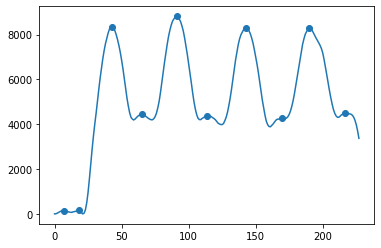

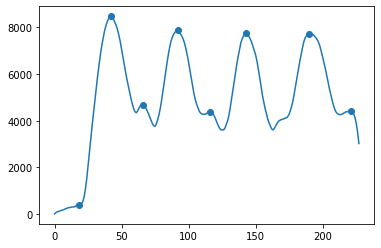

In [11]:
FPS = 25
_, RH_S = calculate_distance(df["R_Hand"], FPS)
_, LH_S = calculate_distance(df["L_Hand"], FPS)

RHsmooth = signal.savgol_filter(RH_S,15,5)
LHsmooth = signal.savgol_filter(LH_S,15,5)

R_peaks, R_prom = signal.find_peaks(RHsmooth, height=0.2, prominence=0.2, distance=5)
L_peaks, L_prom = signal.find_peaks(LHsmooth, height=0.2, prominence=0.2, distance=5)
R_prom = R_prom["peak_heights"]
L_prom = L_prom["peak_heights"]

print(R_peaks)
print(R_prom)
plt.plot(RHsmooth)
plt.scatter(R_peaks,R_prom)
plt.show()
plt.plot(LHsmooth)
plt.scatter(L_peaks,L_prom)
plt.show()

Examining the two plots, it looks like the difference results in a slightly less smooth movement by the right hand during the initial pre-preparation phase, and again towards the end of the gesture. This plotting is a good way to check and determine if our calculation is sensitive enough, or too sensitive for what we are interested in capturing! In this case, it's probably too sensitive (although some of these in-between peaks may be theoretically interesting), particularly the early ones. This may also affect other features that are calculated based on the peak analysis, such as Hold-Time.

<b>Hold-time</b><br>
We already mentioned holds in the previous feature. These can be very interesting, as they help to segregate complex gestures, but also can be used to emphasize particular movements or configurations, hold the floor, etc. The code block below is fairly long, but the idea is to simply check each joint (elbow, hand) for movement. The thresholds being applied are fairly arbitrary and can be fine-tuned if you want the holds to be more or less strictly defined. But what we want to get out of this, is how much time is spent "paused" during a gesture, and how many times these pauses (holds) occur. <br>
Aside from the typical dataframe and FPS inputs, we also ask for the locations of submovements as input. This is because we don't want any time at the beginning or end of an annotation to be taken as a hold. This is helpful if the annotation starts or ends when there is not any movement, which is exactly the case in this pantomime video. 

In [12]:


def find_movepauses(velocity_array):
    # finds moments when velocity is below a particular threshold
    # We are using a 10px/s threshold, but this can be adjusted
    # returns array of indices for those moments

    pause_ix = []
    for index, velpoint in enumerate(velocity_array):

        if velpoint < 10:
            pause_ix.append(index)
    if len(pause_ix) == 0:
        pause_ix = 0

    return pause_ix


def calc_holds(df, subslocs_L, subslocs_R, FPS, hand):
    # calculates the number of holds, time spent in a hold, and the average duration of any holds


    # elbow
    _, RE_S = calculate_distance(df["RElb"], FPS)  # R elbow velocity
    GERix = find_movepauses(RE_S)
    # hand
    _, RH_S = calculate_distance(df["R_Hand"], FPS)
    GRix = find_movepauses(RH_S)
    # finger
    if "R_finger" in df.columns:
        _, RF_S = calculate_distance(df["R_finger"], FPS)
        GFRix = find_movepauses(RF_S)
    else: # if finger data isn't available, we take it to be the same as the hand (just for ease of function)
        GFRix = GRix

    # now find holds for the entire right side
    GR = []
    if isinstance(GERix, list) and isinstance(GRix, list) and isinstance(GFRix, list):
        for handhold in GRix:
            for elbowhold in GERix:
                for fingerhold in GFRix:
                    if handhold == elbowhold:
                        if elbowhold == fingerhold:
                            GR.append(handhold)  # this is all holds of the entire right side


    # elbow
    _, LE_S = calculate_distance(df["LElb"], FPS)  # L elbow velocity
    GELix = find_movepauses(LE_S)
    # hand
    _, LH_S = calculate_distance(df["L_Hand"], FPS)
    GLix = find_movepauses(LH_S)
    # finger
    if "L_finger" in df.columns:
        _, LF_S = calculate_distance(df["L_finger"], FPS)
        GFLix = find_movepauses(LF_S)
    else:
        GFLix = GLix

    # now find holds for the entire right side
    if isinstance(GELix, list) and isinstance(GLix, list) and isinstance(GFLix, list):
        GL = []
        for handhold in GLix:
            for elbowhold in GELix:
                for fingerhold in GFLix:
                    if handhold == elbowhold:
                        if elbowhold == fingerhold:
                            GL.append(handhold)  # this is all holds of the entire right side
                            
    if (hand == 'B' and 'GL' in locals() and 'GR' in locals()) or \
            (hand == 'L' and 'GL' in locals()) or (hand == 'R' and 'GR' in locals()):
        # find holds involving both hands
        full_hold = []
        if hand == 'B':
            for left_hold in GL:  # check, for each left hold,
                for right_hold in GR:  # if there is a corresponding right hold
                    if left_hold == right_hold:
                        full_hold.append(left_hold)  # this is the time position of the hold
        elif hand == 'L':
            full_hold = GL
        elif hand == 'R':
            full_hold = GR

        # now we need to cluster them together
        if len(full_hold) > 0:
            full_hold = [9, 13, 14, 15, 19]
            hold_cluster = [[full_hold[0]]]
            clustercount = 0
            holdcount = 1
            for idx in range(1, len(full_hold)):
                # if the next element of the full_hold list is not equal to the previous value,
                if full_hold[idx] != hold_cluster[clustercount][holdcount - 1] + 1:
                    clustercount += 1
                    holdcount = 1
                    hold_cluster.append([full_hold[idx]])  # then start a new cluster
                else:  # otherwise add the current hold to the current cluster
                    hold_cluster[clustercount].append(full_hold[idx])
                    holdcount += 1

            # we don't want holds occuring at the very beginning or end of an analysis segment
            # so we define these points as the first and last submovement, and remove all holds
            # outside these boundaries
            if hand == 'B':
                initial_move = min(np.concatenate((subslocs_L,subslocs_R),axis=None))
            elif hand == 'L':
                initial_move = min(subslocs_L)
            elif hand == 'R':
                initial_move = min(subslocs_R)


            for index in range(0, len(hold_cluster)):
                if hold_cluster[0][0] < initial_move:
                    hold_cluster.pop(0)

            # now for the summary stats: find the total hold time
            hold_count = 0
            hold_time = 0
            hold_avg = []

            for index in range(0, len(hold_cluster)):
                if len(hold_cluster[index]) >= 3:
                    hold_count += 1  # total number of single holds
                    hold_time += len(hold_cluster[index])  # get the number of frames
                    hold_avg.append(len(hold_cluster[index]))  # used to calculate average holdtime

            hold_time /= FPS  # divide by FPS to get actual time
            hold_avg = statistics.mean(hold_avg)

            return hold_count, hold_time, hold_avg

        else:  # if no full holds were found, return 0s
            hold_count = 0
            hold_time = 0
            hold_avg = 0
            return hold_count, hold_time, hold_avg
    else:
        hold_count = 0
        hold_time = 0
        hold_avg = 0
        return hold_count, hold_time, hold_avg

hold_count, hold_time, hold_avg = calc_holds(df, L_peaks, R_peaks, 25, "B")
print("Number of holds: " + str(hold_count))

Number of holds: 1


Somewhat surprisingly, we do get one hold calculated. We can be pretty confident it comes about because of the very early peaks shown above, which throws off our estimation of when the movement <i>really</i> started. This is also a good metric for tuning your parameters. With even a couple of example cases for which you annotate the number of holds and/or submovements, you can quickly optimize these values to get something similar and then run these automatic calculations on the rest of your data. 

<b>Rhythmicity</b>

In [13]:
      
def calc_rhythm_stability(peaks):
    # calculates the temporal variability of a gesture (ie., the opposite of isochrony)
    # Summarized as the standard deviation of the temporal interval between submovements
    # based on Pouw et al., Multiscale kinematic analysis reveals structural properties of change in evolving manual languages in the lab 
    # (2021): DOI: 10.1111/cogs.13014
    # higher scores indicate more temporal variability, and thus less stable rhythm
    if len(peaks) >= 3:
        # first get temporal interval (in frames) between submovements
        temp_interval = [peaks[idx]-peaks[idx-1] for idx in range(1,len(peaks))]
        # intermittency is the variance of these intervals
        stability = np.std(temp_interval)

    else:
       stability= float('nan')
    return stability

R_rhythm = calc_rhythm_stability(R_peaks)
L_rhythm = calc_rhythm_stability(L_peaks)

print(R_rhythm)
print(L_rhythm)

5.0990195135927845
7.708992893275452


## Comparison with MediaPipe

Finally, let's also see how we would convert the MediaPipe files into a suitable format. It's quick and easy with a script, although you could also adjust the output format of the MediaPipe tracking code, or adjust the kinematic feature analysis inputs. 

In [14]:
df_MP = pd.read_csv(os.path.join(data_path, "ACCORDION_silentgesture_MP.csv"))

df_MP.head()

,time,X_NOSE,Y_NOSE,Z_NOSE,visibility_NOSE,X_LEFT_EYE_INNER,Y_LEFT_EYE_INNER,Z_LEFT_EYE_INNER,visibility_LEFT_EYE_INNER,X_LEFT_EYE,...,Z_RIGHT_HEEL,visibility_RIGHT_HEEL,X_LEFT_FOOT_INDEX,Y_LEFT_FOOT_INDEX,Z_LEFT_FOOT_INDEX,visibility_LEFT_FOOT_INDEX,X_RIGHT_FOOT_INDEX,Y_RIGHT_FOOT_INDEX,Z_RIGHT_FOOT_INDEX,visibility_RIGHT_FOOT_INDEX
0,0,-0.053149,-0.567753,-0.302702,0.999662,-0.042548,-0.613559,-0.272078,0.999388,-0.036887,...,0.173944,0.022878,0.001725,0.750673,0.165060,0.030264,-0.089742,0.736495,0.120012,0.044898
1,20,-0.053406,-0.567024,-0.302721,0.999681,-0.042504,-0.613096,-0.272296,0.999423,-0.036846,...,0.151073,0.022425,0.000193,0.745604,0.174823,0.029050,-0.092870,0.746669,0.091794,0.045378
2,40,-0.053790,-0.566054,-0.302748,0.999701,-0.042501,-0.612441,-0.272503,0.999458,-0.036844,...,0.143897,0.022066,-0.001189,0.740421,0.176131,0.028095,-0.095949,0.752635,0.083965,0.045964
3,60,-0.054175,-0.564885,-0.302864,0.999717,-0.042533,-0.611569,-0.272861,0.999487,-0.036885,...,0.136660,0.021814,-0.002180,0.739484,0.176961,0.027226,-0.099196,0.754842,0.077332,0.046375
4,80,-0.054822,-0.563258,-0.303625,0.999732,-0.042721,-0.610237,-0.274059,0.999515,-0.037081,...,0.135180,0.021639,-0.002585,0.735729,0.179721,0.026472,-0.099636,0.756050,0.075470,0.047073


As a reminder, we can see that the main differences are that the naming conventions are slightly different, and the dataframe has one column for each axis (i.e., a column for an x value, and a column for a y-value). This will often be the case when we work with different tracking methods, or collaborate and use data from others. So it's useful to be able to shift your data format around to meet your needs.<br>
It's important to note that not all keypoints tracked by OpenPose are also tracked by MediaPipe. For many features this isn't an issue, but for some we utilize more detailed information (in the form of additional keypoints) to make calculations about what the hands are doing in relation to the body. A useful exercise would be to see if you can approximate these locations based on the keypoints that we do have. If you look at the first lines in the calc_vertical_amplitude code, this is exactly what I do already. This would just need to be extended based on the number of keypoints MediaPipe offers.

In [15]:

def convert_MP_to_OP(df_MP):
    # first we create a dictionary that maps the names in our MediaPipe output to the names in our OpenPose output
    conv_dict = {"RIGHT_WRIST":"R_Hand", "LEFT_WRIST":"L_Hand","NOSE":"Nose","RIGHT_ELBOW":"RElb","LEFT_ELBOW":"LElb","RIGHT_HIP":"RHip","LEFT_HIP":"LHip", "LEFT_EYE":"LEye","RIGHT_EYE":"REye"}
    
    OP_df = pd.DataFrame()
    
    for key in conv_dict:
        
        OP_df[conv_dict[key]] = [[row["X_"+key],row["Y_"+key],row["Z_"+key]] for _,row in df_MP.iterrows()]
    OP_df["time"] = df_MP["time"].copy()
    
    # NOTE: not all methods track the exact same keypoints. For some of our calculations we need a Neck point, and a Mid-Hip Point.
    # We need to calculate these based on others
    OP_df["Neck"] = [[np.mean([row["X_LEFT_SHOULDER"],row["Y_RIGHT_SHOULDER"]]),np.mean([row["X_LEFT_SHOULDER"],row["Y_LEFT_SHOULDER"]]),row["Z_RIGHT_SHOULDER"] ] for _, row in df_MP.iterrows()]
    OP_df["MidHip"] = [[np.mean([row["X_LEFT_HIP"],row["X_RIGHT_HIP"]]),np.mean([row["Y_LEFT_HIP"],row["Y_LEFT_HIP"]]),row["Z_RIGHT_HIP"] ] for _, row in df_MP.iterrows()]
    return OP_df

MP_df_conv = convert_MP_to_OP(df_MP)                                   
MP_df_conv.head()
    

,R_Hand,L_Hand,Nose,RElb,LElb,RHip,LHip,LEye,REye,time,Neck,MidHip
0,"[-0.2418335676193237, -0.0483077615499496, -0....","[0.2037657648324966, 0.0489371232688427, -0.25...","[-0.0531491339206695, -0.5677530169487, -0.302...","[-0.1861211657524109, -0.202798306941986, -0.1...","[0.2398913502693176, -0.1924007385969162, -0.2...","[-0.0802412033081054, 0.0204129833728075, 0.04...","[0.1001041084527969, 0.0084177628159523, 0.034...","[-0.0368865504860878, -0.6110665798187256, -0....","[-0.0557566694915294, -0.6388819813728333, -0....",0,"[-0.11737709492444996, -0.11609657853841786, -...","[0.009931452572345748, 0.0084177628159523, 0.0..."
1,"[-0.2420343905687332, -0.0564501881599426, -0....","[0.2018328607082367, 0.046357836574316, -0.250...","[-0.0534058958292007, -0.5670242309570312, -0....","[-0.1859343349933624, -0.2063875496387481, -0....","[0.2386743575334549, -0.1972924321889877, -0.2...","[-0.0795021131634712, 0.0204320792108774, 0.04...","[0.0992705225944519, 0.0082980748265981, 0.035...","[-0.0368464887142181, -0.6103816628456116, -0....","[-0.0557324327528476, -0.6384509205818176, -0....",20,"[-0.11862092465162281, -0.11775954812765126, -...","[0.009884204715490355, 0.0082980748265981, 0.0..."
2,"[-0.2423559874296188, -0.0608672201633453, -0....","[0.2009023576974868, 0.0453667640686035, -0.24...","[-0.0537895336747169, -0.5660539269447327, -0....","[-0.1858183741569519, -0.2088533788919448, -0....","[0.237737700343132, -0.19996178150177, -0.2027...","[-0.0789888575673103, 0.0204502753913402, 0.04...","[0.0987033098936081, 0.008213304914534, 0.0358...","[-0.0368437021970748, -0.6095432639122009, -0....","[-0.0557449050247669, -0.6378147602081299, -0....",40,"[-0.11964139342308044, -0.11891807615756986, -...","[0.009857226163148894, 0.008213304914534, 0.04..."
3,"[-0.2425440549850464, -0.0638030096888542, -0....","[0.2007066160440445, 0.0452104210853576, -0.24...","[-0.0541746988892555, -0.5648845434188843, -0....","[-0.18548384308815, -0.210270270705223, -0.127...","[0.23712719976902, -0.2010623514652252, -0.202...","[-0.0785336941480636, 0.0204645302146673, 0.04...","[0.0982132628560066, 0.0081632183864712, 0.036...","[-0.0368850268423557, -0.6085212826728821, -0....","[-0.0558072179555892, -0.6368656754493713, -0....",60,"[-0.12034758925437931, -0.119682788848877, -0....","[0.009839784353971495, 0.0081632183864712, 0.0..."
4,"[-0.2431727051734924, -0.0654325038194656, -0....","[0.2002329230308532, 0.0455453358590602, -0.24...","[-0.0548219196498394, -0.56325763463974, -0.30...","[-0.1854152083396911, -0.2111085206270218, -0....","[0.2363915741443634, -0.2011899054050445, -0.2...","[-0.0782021209597587, 0.0204872358590364, 0.04...","[0.0978424400091171, 0.0080899316817522, 0.036...","[-0.0370814576745033, -0.6070913076400757, -0....","[-0.0560496635735034, -0.6355066895484924, -0....",80,"[-0.1207819953560829, -0.12012919038534166, -0...","[0.009820159524679198, 0.0080899316817522, 0.0..."


Let's see how the two data sources compare

In [17]:
volume = calc_volume_size(df,'B')
print('Volumetric space from OpenPose: ' + str(volume) + " pixels")
volume = calc_volume_size(MP_df_conv,'B')
print('Volumetric space from MediaPipe: ' + str(volume) + " meters")
print("\n")

PV_R = calc_peakVel(df["R_Hand"],25)
print("Right hand peak velocity from OpenPose: " + str(PV_R) + " px/s")
PV_R = calc_peakVel(MP_df_conv["R_Hand"],25)
print("Right hand peak velocity from MediaPipe: " + str(PV_R) + " meters/s")
print("\n")
Lsubs, Rsubs, L_peaks, R_peaks = calc_submoves(df, 25, 'B')
Lsubs_MP, Rsubs_MP, _, _ = calc_submoves(MP_df_conv, 25, 'B')

print("number of right hand movements from OpenPose: " + str(Rsubs))
print("number of right hand movements from MediaPipe: " + str(Rsubs_MP))


Volumetric space from OpenPose: 77809.63585499996 pixels
Volumetric space from MediaPipe: 0.08057921334485438 meters


Right hand peak velocity from OpenPose: 8821.294458244305 px/s
Right hand peak velocity from MediaPipe: 10.26647717910366 meters/s


number of right hand movements from OpenPose: 11
number of right hand movements from MediaPipe: 6


There are two important differences here. First, the different methods give you coordinates in different spaces (pixels vs meters). This means directly comparing between methods can be tricky.<br>
Second, we see that the submovement calculation differs between the two, despite the velocity profile looking quite similar (as shown in the OpenPose tracking method). Let's take a closer look at how the submovements compare between the two.

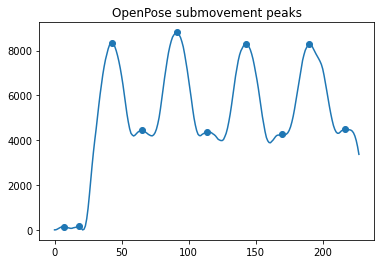

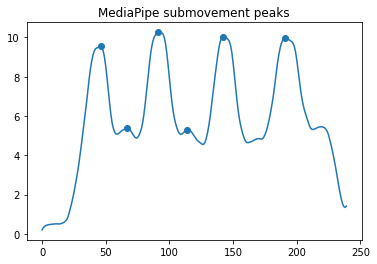

In [18]:
# OpenPose
_, RH_S = calculate_distance(df["R_Hand"], FPS)
_, LH_S = calculate_distance(df["L_Hand"], FPS)

RHsmooth = signal.savgol_filter(RH_S,15,5)
LHsmooth = signal.savgol_filter(LH_S,15,5)

R_peaks, R_prom = signal.find_peaks(RHsmooth, height=0.2, prominence=0.2, distance=5)
L_peaks, L_prom = signal.find_peaks(LHsmooth, height=0.2, prominence=0.2, distance=5)
R_prom = R_prom["peak_heights"]
L_prom = L_prom["peak_heights"]

# MediaPipe
_, RH_S_MP = calculate_distance(MP_df_conv["R_Hand"], FPS)
_, LH_S_MP = calculate_distance(MP_df_conv["L_Hand"], FPS)

RHsmooth_MP = signal.savgol_filter(RH_S_MP,15,5)
LHsmooth_MP = signal.savgol_filter(LH_S_MP,15,5)

R_peaks_MP, R_prom_MP = signal.find_peaks(RHsmooth_MP, height=0.2, prominence=0.2, distance=5)
L_peaks_MP, L_prom_MP = signal.find_peaks(LHsmooth_MP, height=0.2, prominence=0.2, distance=5)
R_prom_MP = R_prom_MP["peak_heights"]
L_prom_MP = L_prom_MP["peak_heights"]


plt.plot(RHsmooth)
plt.scatter(R_peaks,R_prom)
plt.title("OpenPose submovement peaks")
plt.show()
plt.plot(RHsmooth_MP)
plt.scatter(R_peaks_MP,R_prom_MP)
plt.title("MediaPipe submovement peaks")
plt.show()

In some sense the MediaPipe plot looks cleaner. This shows how calibration is quite important for ensuring that differences in recording don't have too strong of an influence on your results. <br>
<b>Open Question</b>
Are there ways to standardize velocity and/or position in such a way that individual differences remain, but recording-specific differences are removed?

## <b>Processing a full video </b>  
Next, let's see how the code works with the data that we just processed, using our manual annotations as a starting point.

In [19]:
import pympi

In [20]:
# this is usually the name of the video, and should be the same as 
# the name of the motion tracking data and the annotation file
filename_short = "V07"

df_MT = pd.read_csv(os.path.join("Timeseries_Output", filename_short + ".csv"))
df_MT_conv = convert_MP_to_OP(df_MT)                                   

# first we need to access our annotations
filename = "Annotations/" + filename_short + ".eaf"
eafob = pympi.Elan.Eaf(filename)

# make sure you set the name of the tier where the annotations of interest are located
gesture_annots = eafob.get_annotation_data_for_tier("gestures")

# then we can look through each annotation, and calculate our kinematic values
file_list = []
g_index_list = []
PV_R_list = []
Lsubs_list = []
Rsubs_list = []
rhythm_L_list = []
rhythm_R_list = []
mode_L_list = []
mode_R_list = []

g_index = 1
for annot in gesture_annots:
    # this first line just takes the rows that correspond to our annotation
    g_data = df_MT_conv[(df_MT_conv.time >= annot[0]) & (df_MT_conv.time <= annot[1])]
    g_data.reset_index(inplace=True)
    
    if len(g_data) > 10:
    
        PV_R = calc_peakVel(g_data["R_Hand"],25)
        Lsubs, Rsubs, L_peaks, R_peaks = calc_submoves(g_data, 25, 'B')
        R_rhythm = calc_rhythm_stability(R_peaks)
        L_rhythm = calc_rhythm_stability(L_peaks)
        space_use_L, space_use_R, mcneillian_maxL, mcneillian_maxR, mcneillian_modeL, mcneillian_modeR = calc_mcneillian_space(g_data, "B")


        # now store them all in a dataframe
        file_list.append(filename)
        g_index_list.append(g_index)
        PV_R_list.append(PV_R)
        Lsubs_list.append(Lsubs)
        Rsubs_list.append(Rsubs)
        rhythm_L_list.append(L_rhythm)
        rhythm_R_list.append(R_rhythm)
        mode_L_list.append(mcneillian_modeL)
        mode_R_list.append(mcneillian_modeR)

        g_index += 1
    
df = pd.DataFrame(np.column_stack([file_list, g_index_list,
                                  PV_R_list, Lsubs_list, Rsubs_list,
                                  rhythm_L_list, rhythm_R_list,
                                   mode_L_list,  mode_R_list]),
                 columns = ["file", "gesture", 
                           "PeakVelocity_R", "Submovements_L","Submovements_R",
                           "Rhythm_L", "Rhythm_R",
                           "MN_mode_L","MN_mode_R"])
    

In [42]:
df.head()

,file,gesture,PeakVelocity_R,Submovements_L,Submovements_R,Rhythm_L,Rhythm_R,MN_mode_L,MN_mode_R
0,Annotations/V07.eaf,1,0.4980699555412888,1,1,nan,nan,4,2
1,Annotations/V07.eaf,2,0.9730391445687233,0,1,nan,nan,4,4
2,Annotations/V07.eaf,3,0.5633653260635442,0,1,nan,nan,4,2
3,Annotations/V07.eaf,4,5.408648671608639,1,2,nan,nan,2,2


Compare the above values with what the actual annotations in ELAN. Do they match what you might expect? 

# Fine-Tuning Parameters
It's not bad, but the submovement analysis, and thus also the Rhythm calculation,  doesn't seem to be fully capturing smaller movements. Let's see if we can do something about that.

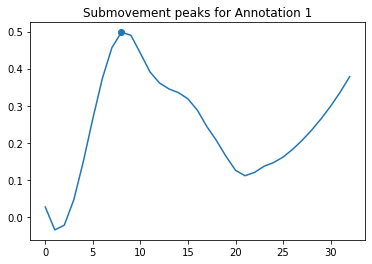

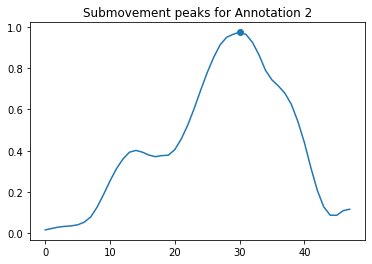

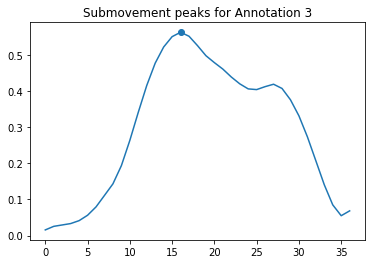

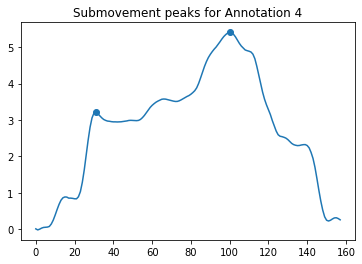

In [22]:
annot_num = 1
for annot in gesture_annots:
    # this first line just takes the rows that correspond to our annotation
    g_data = df_MT_conv[(df_MT_conv.time >= annot[0]) & (df_MT_conv.time <= annot[1])]
    g_data.reset_index(inplace=True)

    _, RH_S_MP = calculate_distance(g_data["R_Hand"], FPS)

    RHsmooth_MP = signal.savgol_filter(RH_S_MP,15,5)

    R_peaks_MP, R_prom_MP = signal.find_peaks(RHsmooth_MP, height=0.2, prominence=0.2, distance=5)
    R_prom_MP = R_prom_MP["peak_heights"]


    plt.plot(RHsmooth_MP)
    plt.scatter(R_peaks_MP,R_prom_MP)
    plt.title("Submovement peaks for Annotation " + str(annot_num))
    plt.show()
    
    annot_num = annot_num +1

The two most straightforward things to do are to adjust the smoothing parameters, and to adjust the peak detection parameters. Let's take a look at what happens when we adjust these. 

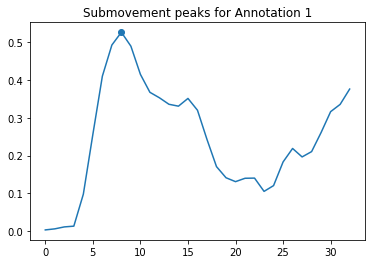

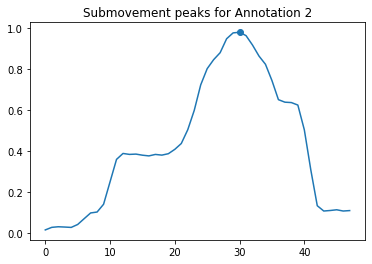

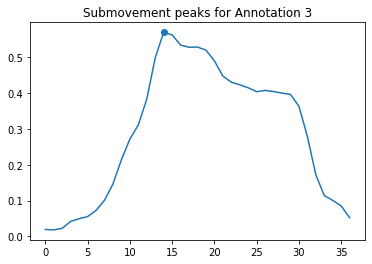

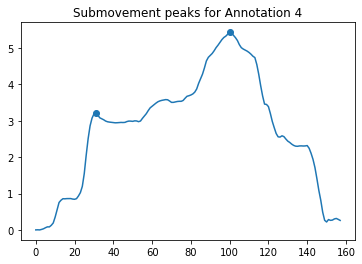

In [46]:
annot_num = 1
for annot in gesture_annots:
    # this first line just takes the rows that correspond to our annotation
    g_data = df_MT_conv[(df_MT_conv.time >= annot[0]) & (df_MT_conv.time <= annot[1])]
    g_data.reset_index(inplace=True)

    _, RH_S_MP = calculate_distance(g_data["R_Hand"], FPS)

    RHsmooth_MP = signal.savgol_filter(RH_S_MP,7,5)

    R_peaks_MP, R_prom_MP = signal.find_peaks(RHsmooth_MP, height=0.2, prominence=0.2, distance=5)
    R_prom_MP = R_prom_MP["peak_heights"]


    plt.plot(RHsmooth_MP)
    plt.scatter(R_peaks_MP,R_prom_MP)
    plt.title("Submovement peaks for Annotation " + str(annot_num))
    plt.show()
    
    annot_num = annot_num +1

Now let's make the peak detection more sensitive (returning smoothing to the original values, so we can compare) by adjusting the prominence value. Prominence denotes how much a peak needs to stick out from the surrounding data.

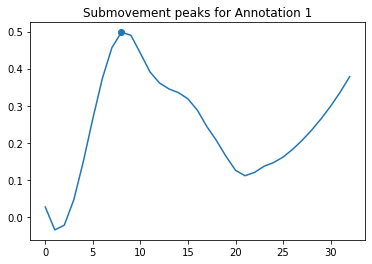

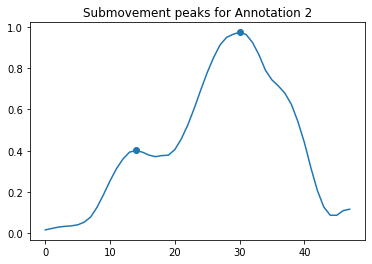

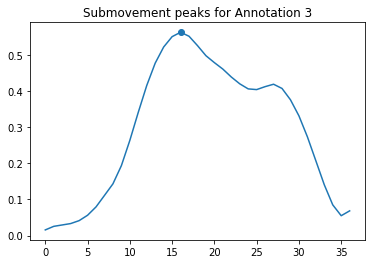

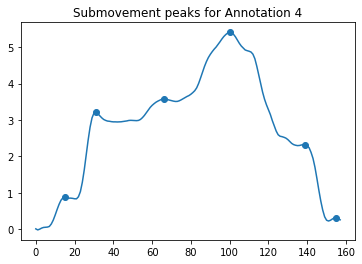

In [21]:
annot_num = 1
for annot in gesture_annots:
    # this first line just takes the rows that correspond to our annotation
    g_data = df_MT_conv[(df_MT_conv.time >= annot[0]) & (df_MT_conv.time <= annot[1])]
    g_data.reset_index(inplace=True)

    _, RH_S_MP = calculate_distance(g_data["R_Hand"], FPS)

    RHsmooth_MP = signal.savgol_filter(RH_S_MP,15,5)

    R_peaks_MP, R_prom_MP = signal.find_peaks(RHsmooth_MP, height=0.2, prominence=0.025, distance=5)
    R_prom_MP = R_prom_MP["peak_heights"]


    plt.plot(RHsmooth_MP)
    plt.scatter(R_peaks_MP,R_prom_MP)
    plt.title("Submovement peaks for Annotation " + str(annot_num))
    plt.show()
    
    annot_num = annot_num +1

Does this match better with what you see in the video? Can you tune it further? 